Multi-channel CSC
=================

This example demonstrates convolutional sparse coding of a colour signal with a product dictionary [[24]](http://sporco.rtfd.org/en/latest/zreferences.html#garcia-2018-convolutional2)

  $$\mathrm{argmin}_X \; \left\| D X B^T - S \right\|_1 + \lambda \| X \|_1$$

where $D$ is a convolutional dictionary, $B$ is a standard dictionary, and $S$ is a multi-channel input image.

This example uses the GPU accelerated version of [admm.pdcsc](http://sporco.rtfd.org/en/latest/modules/sporco.admm.pdcsc.html#module-sporco.admm.pdcsc) within the [sporco.cupy](http://sporco.rtfd.org/en/latest/modules/sporco.cupy.html#module-sporco.cupy) subpackage.

In [1]:
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import signal
from sporco import fft
from sporco import linalg
from sporco import plot
plot.config_notebook_plotting()
from sporco import metric
from sporco.cupy import (cupy_enabled, np2cp, cp2np, select_device_by_load,
                         gpu_info)
from sporco.cupy.admm import pdcsc
from sporco.dictlrn import bpdndl

Load example image.

In [2]:
img = util.ExampleImages().image('kodim23.png', scaled=True,
                                 idxexp=np.s_[160:416,60:316])

Highpass filter example image.

In [3]:
npd = 16
fltlmbd = 10
slc, shc = signal.tikhonov_filter(img, fltlmbd, npd)

Load greyscale convolutional dictionary.

In [4]:
D = util.convdicts()['G:8x8x64']

Learn a standard dictionary $B$ to represent all pixel colours in the example image. Since the standard dictionary is a $3 \times 6$ matrix, the sparse representation $X$ has 6 pseudo-channels, which are converted to the 3 channels of the example image by right-multiplication by the dictionary $B$, giving $XB$.

In [5]:
S = shc.reshape((-1, shc.shape[-1])).T
np.random.seed(12345)
B0 = np.random.randn(S.shape[0], 6)
lmbda = 1e-2
opt = bpdndl.BPDNDictLearn.Options(
    {'Verbose': True, 'MaxMainIter': 100,
     'BPDN': {'rho': 10.0*lmbda, 'AutoRho': {'Enabled': False}},
     'CMOD': {'rho': S.shape[1] / 3e2, 'AutoRho': {'Enabled': False}}})

d = bpdndl.BPDNDictLearn(B0, S, lmbda, opt)
B = d.solve()

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  1.28e+02  9.77e+01  3.00e+03  9.28e-02  4.88e-01  1.20e+00  1.00e-01  5.53e-02  1.34e+00  2.18e+02
   1  9.43e+01  5.17e+01  4.25e+03  1.18e-01  3.37e-01  6.04e-01  1.00e-01  7.91e-02  1.50e+00  2.18e+02
   2  6.24e+01  2.38e+01  3.86e+03  1.15e-01  2.43e-01  3.39e-01  1.00e-01  5.40e-02  1.46e+00  2.18e+02
   3  5.59e+01  1.59e+01  4.00e+03  8.68e-02  1.94e-01  1.62e-01  1.00e-01  3.63e-02  8.59e-01  2.18e+02
   4  5.48e+01  1.28e+01  4.20e+03  6.08e-02  1.48e-01  1.40e-01  1.00e-01  2.53e-02  3.12e-01  2.18e+02
   5  5.23e+01  1.08e+01  4.14e+03  5.07e-02  1.12e-01  1.25e-01  1.00e-01  2.05e-02  1.05e-01  2.18e+02
   6  5.09e+01  8.96e+00  4.20e+03  4.02e-02  8.93e-02  7.65e-02  1.00e-01  1.66e-02  9.90e-02  2.18e+02
   7  5.05e+01  7.72e+00  4.28e+03  3.05e-02  7.18e-02 

  10  4.96e+01  6.78e+00  4.28e+03  1.23e-02  3.91e-02  2.95e-02  1.00e-01  6.05e-03  1.18e-01  2.18e+02
  11  4.95e+01  6.78e+00  4.27e+03  1.02e-02  3.35e-02  2.74e-02  1.00e-01  5.49e-03  1.23e-01  2.18e+02
  12  4.93e+01  6.43e+00  4.29e+03  7.38e-03  2.95e-02  2.33e-02  1.00e-01  4.87e-03  1.29e-01  2.18e+02
  13  4.92e+01  6.28e+00  4.30e+03  6.19e-03  2.61e-02  1.99e-02  1.00e-01  4.72e-03  1.35e-01  2.18e+02
  14  4.91e+01  6.25e+00  4.29e+03  4.46e-03  2.42e-02  1.86e-02  1.00e-01  4.52e-03  1.39e-01  2.18e+02
  15  4.91e+01  6.10e+00  4.30e+03  3.63e-03  2.26e-02  1.72e-02  1.00e-01  4.53e-03  1.43e-01  2.18e+02
  16  4.90e+01  6.01e+00  4.30e+03  2.56e-03  2.16e-02  1.61e-02  1.00e-01  4.46e-03  1.46e-01  2.18e+02
  17  4.89e+01  5.96e+00  4.30e+03  2.21e-03  2.10e-02  1.56e-02  1.00e-01  4.54e-03  1.49e-01  2.18e+02
  18  4.88e+01  5.81e+00  4.30e+03  1.44e-03  2.06e-02  1.61e-02  1.00e-01  4.83e-03  1.62e-01  2.18e+02
  19  4.88e+01  5.75e+00  4.30e+03  1.67e-03  2.14e-02 

  26  4.80e+01  5.17e+00  4.28e+03  7.28e-04  2.13e-02  1.55e-02  1.00e-01  4.84e-03  1.67e-01  2.18e+02
  27  4.79e+01  5.09e+00  4.28e+03  7.84e-04  1.87e-02  1.36e-02  1.00e-01  4.36e-03  1.51e-01  2.18e+02
  28  4.78e+01  5.01e+00  4.28e+03  1.02e-03  1.68e-02  1.23e-02  1.00e-01  4.13e-03  1.44e-01  2.18e+02
  29  4.77e+01  4.95e+00  4.27e+03  8.73e-04  1.59e-02  1.21e-02  1.00e-01  4.03e-03  1.42e-01  2.18e+02
  30  4.76e+01  4.92e+00  4.27e+03  5.03e-04  1.57e-02  1.16e-02  1.00e-01  4.02e-03  1.43e-01  2.18e+02
  31  4.76e+01  4.90e+00  4.27e+03  2.29e-04  1.57e-02  1.06e-02  1.00e-01  4.06e-03  1.45e-01  2.18e+02
  32  4.75e+01  4.87e+00  4.27e+03  1.43e-04  1.55e-02  9.78e-03  1.00e-01  4.03e-03  1.44e-01  2.18e+02
  33  4.75e+01  4.82e+00  4.27e+03  2.94e-04  1.48e-02  9.41e-03  1.00e-01  3.89e-03  1.39e-01  2.18e+02
  34  4.74e+01  4.76e+00  4.27e+03  4.30e-04  1.39e-02  8.77e-03  1.00e-01  3.66e-03  1.31e-01  2.18e+02
  35  4.74e+01  4.71e+00  4.27e+03  5.42e-04  1.29e-02 

  42  4.71e+01  4.55e+00  4.26e+03  2.87e-04  1.04e-02  6.03e-03  1.00e-01  2.99e-03  1.10e-01  2.18e+02
  43  4.71e+01  4.52e+00  4.26e+03  4.04e-04  9.99e-03  5.70e-03  1.00e-01  2.92e-03  1.08e-01  2.18e+02
  44  4.71e+01  4.50e+00  4.26e+03  4.50e-04  9.56e-03  5.52e-03  1.00e-01  2.84e-03  1.05e-01  2.18e+02
  45  4.70e+01  4.48e+00  4.25e+03  4.06e-04  9.19e-03  5.37e-03  1.00e-01  2.78e-03  1.04e-01  2.18e+02
  46  4.70e+01  4.46e+00  4.25e+03  3.24e-04  8.93e-03  5.14e-03  1.00e-01  2.73e-03  1.02e-01  2.18e+02
  47  4.70e+01  4.45e+00  4.25e+03  2.55e-04  8.76e-03  4.96e-03  1.00e-01  2.70e-03  1.01e-01  2.18e+02
  48  4.69e+01  4.44e+00  4.25e+03  1.80e-04  8.66e-03  4.87e-03  1.00e-01  2.67e-03  1.00e-01  2.18e+02
  49  4.69e+01  4.43e+00  4.25e+03  1.65e-04  8.61e-03  4.78e-03  1.00e-01  2.64e-03  9.93e-02  2.18e+02
  50  4.69e+01  4.42e+00  4.25e+03  1.83e-04  8.55e-03  4.65e-03  1.00e-01  2.61e-03  9.84e-02  2.18e+02
  51  4.69e+01  4.41e+00  4.25e+03  2.32e-04  8.44e-03 

  59  4.67e+01  4.34e+00  4.24e+03  1.90e-04  7.74e-03  3.90e-03  1.00e-01  2.40e-03  9.24e-02  2.18e+02
  60  4.67e+01  4.34e+00  4.24e+03  2.16e-04  7.70e-03  3.85e-03  1.00e-01  2.38e-03  9.18e-02  2.18e+02
  61  4.67e+01  4.33e+00  4.24e+03  2.31e-04  7.64e-03  3.85e-03  1.00e-01  2.36e-03  9.11e-02  2.18e+02
  62  4.67e+01  4.32e+00  4.23e+03  2.34e-04  7.58e-03  3.81e-03  1.00e-01  2.33e-03  9.05e-02  2.18e+02
  63  4.66e+01  4.31e+00  4.23e+03  2.32e-04  7.52e-03  3.71e-03  1.00e-01  2.31e-03  8.97e-02  2.18e+02
  64  4.66e+01  4.31e+00  4.23e+03  2.19e-04  7.46e-03  3.63e-03  1.00e-01  2.28e-03  8.87e-02  2.18e+02
  65  4.66e+01  4.30e+00  4.23e+03  2.01e-04  7.39e-03  3.59e-03  1.00e-01  2.25e-03  8.77e-02  2.18e+02
  66  4.66e+01  4.30e+00  4.23e+03  1.97e-04  7.33e-03  3.52e-03  1.00e-01  2.21e-03  8.66e-02  2.18e+02
  67  4.66e+01  4.29e+00  4.23e+03  2.00e-04  7.26e-03  3.43e-03  1.00e-01  2.18e-03  8.53e-02  2.18e+02
  68  4.66e+01  4.28e+00  4.23e+03  2.02e-04  7.17e-03 

  77  4.65e+01  4.20e+00  4.23e+03  1.96e-04  6.81e-03  3.29e-03  1.00e-01  1.84e-03  7.39e-02  2.18e+02
  78  4.64e+01  4.20e+00  4.22e+03  2.07e-04  6.57e-03  3.14e-03  1.00e-01  1.79e-03  7.18e-02  2.18e+02
  79  4.64e+01  4.19e+00  4.22e+03  2.17e-04  6.32e-03  3.02e-03  1.00e-01  1.73e-03  6.97e-02  2.18e+02
  80  4.64e+01  4.18e+00  4.22e+03  2.17e-04  6.07e-03  2.87e-03  1.00e-01  1.67e-03  6.76e-02  2.18e+02
  81  4.64e+01  4.17e+00  4.22e+03  2.23e-04  5.85e-03  2.71e-03  1.00e-01  1.63e-03  6.58e-02  2.18e+02
  82  4.64e+01  4.16e+00  4.22e+03  2.26e-04  5.66e-03  2.62e-03  1.00e-01  1.59e-03  6.44e-02  2.18e+02
  83  4.64e+01  4.16e+00  4.22e+03  2.18e-04  5.52e-03  2.54e-03  1.00e-01  1.56e-03  6.32e-02  2.18e+02
  84  4.64e+01  4.15e+00  4.22e+03  2.06e-04  5.40e-03  2.49e-03  1.00e-01  1.52e-03  6.21e-02  2.18e+02
  85  4.64e+01  4.15e+00  4.22e+03  2.02e-04  5.30e-03  2.42e-03  1.00e-01  1.49e-03  6.10e-02  2.18e+02
  86  4.64e+01  4.14e+00  4.22e+03  1.93e-04  5.19e-03 

  95  4.63e+01  4.11e+00  4.22e+03  1.71e-04  4.10e-03  1.85e-03  1.00e-01  1.23e-03  5.11e-02  2.18e+02
  96  4.63e+01  4.10e+00  4.22e+03  1.71e-04  4.02e-03  1.79e-03  1.00e-01  1.20e-03  5.02e-02  2.18e+02
  97  4.63e+01  4.10e+00  4.22e+03  1.62e-04  3.93e-03  1.75e-03  1.00e-01  1.18e-03  4.94e-02  2.18e+02
  98  4.63e+01  4.10e+00  4.22e+03  1.61e-04  3.85e-03  1.72e-03  1.00e-01  1.16e-03  4.87e-02  2.18e+02
  99  4.63e+01  4.10e+00  4.22e+03  1.61e-04  3.76e-03  1.68e-03  1.00e-01  1.14e-03  4.80e-02  2.18e+02
--------------------------------------------------------------------------------------------------------


Set [pdcsc.ConvProdDictBPDN](http://sporco.rtfd.org/en/latest/modules/sporco.admm.pdcsc.html#sporco.admm.pdcsc.ConvProdDictBPDN) solver options.

In [6]:
lmbda = 1e-1
opt = pdcsc.ConvProdDictBPDN.Options({'Verbose': True, 'MaxMainIter': 100,
                                      'RelStopTol': 5e-3, 'AuxVarObj': False})

Initialise and run CSC solver.

In [7]:
if not cupy_enabled():
    print('CuPy/GPU device not available: running without GPU acceleration\n')
else:
    id = select_device_by_load()
    info = gpu_info()
    if info:
        print('Running on GPU %d (%s)\n' % (id, info[id].name))

b = pdcsc.ConvProdDictBPDN(np2cp(D), np2cp(B), np2cp(shc), lmbda, opt, dimK=0)
X = cp2np(b.solve())
print("ConvProdDictBPDN solve time: %.2fs" % b.timer.elapsed('solve'))

Running on GPU 0 (GeForce RTX 2080 Ti)



Itn   Fnc       DFid      Regℓ1     r         s         ρ       
----------------------------------------------------------------
   0  4.30e+02  6.96e-01  4.30e+03  1.00e+00  1.86e-03  6.00e+00


   1  3.87e+02  3.95e+00  3.83e+03  9.87e-01  4.14e-02  6.00e+00
   2  3.37e+02  1.35e+01  3.24e+03  8.14e-01  2.59e-01  2.07e+01


   3  2.67e+02  2.62e+01  2.41e+03  3.67e-01  3.45e-01  2.60e+01
   4  2.89e+02  2.83e+01  2.60e+03  2.83e-01  2.30e-01  1.90e+01


   5  2.67e+02  2.68e+01  2.40e+03  2.47e-01  1.57e-01  1.49e+01
   6  2.35e+02  2.67e+01  2.08e+03  2.19e-01  1.18e-01  1.32e+01


   7  2.17e+02  2.74e+01  1.89e+03  1.79e-01  8.78e-02  1.32e+01
   8  2.00e+02  2.84e+01  1.71e+03  1.42e-01  7.38e-02  1.32e+01


   9  1.90e+02  2.90e+01  1.61e+03  1.13e-01  6.49e-02  1.32e+01
  10  1.84e+02  2.94e+01  1.55e+03  9.31e-02  5.71e-02  1.32e+01


  11  1.78e+02  2.95e+01  1.48e+03  8.35e-02  5.05e-02  1.19e+01
  12  1.74e+02  2.95e+01  1.44e+03  7.59e-02  4.44e-02  1.08e+01


  13  1.69e+02  2.96e+01  1.39e+03  6.57e-02  3.92e-02  1.08e+01
  14  1.62e+02  2.96e+01  1.33e+03  5.71e-02  3.56e-02  1.08e+01


  15  1.58e+02  2.97e+01  1.29e+03  5.34e-02  3.28e-02  9.68e+00
  16  1.55e+02  2.99e+01  1.25e+03  5.03e-02  2.99e-02  8.73e+00


  17  1.54e+02  2.99e+01  1.24e+03  4.46e-02  2.70e-02  8.73e+00
  18  1.53e+02  3.00e+01  1.23e+03  4.24e-02  2.48e-02  7.93e+00


  19  1.51e+02  3.00e+01  1.21e+03  3.82e-02  2.30e-02  7.93e+00
  20  1.50e+02  3.00e+01  1.20e+03  3.66e-02  2.15e-02  7.22e+00


  21  1.47e+02  2.99e+01  1.18e+03  3.34e-02  2.01e-02  7.22e+00
  22  1.46e+02  2.99e+01  1.16e+03  3.24e-02  1.88e-02  6.59e+00


  23  1.44e+02  2.99e+01  1.14e+03  2.99e-02  1.75e-02  6.59e+00
  24  1.42e+02  2.99e+01  1.12e+03  2.77e-02  1.64e-02  6.59e+00


  25  1.41e+02  2.99e+01  1.11e+03  2.57e-02  1.55e-02  6.59e+00
  26  1.39e+02  2.99e+01  1.09e+03  2.53e-02  1.47e-02  5.99e+00


  27  1.38e+02  3.00e+01  1.08e+03  2.37e-02  1.40e-02  5.99e+00
  28  1.37e+02  3.00e+01  1.07e+03  2.23e-02  1.33e-02  5.99e+00


  29  1.36e+02  3.00e+01  1.06e+03  2.10e-02  1.27e-02  5.99e+00
  30  1.36e+02  3.00e+01  1.05e+03  2.09e-02  1.21e-02  5.45e+00


  31  1.35e+02  3.01e+01  1.05e+03  1.98e-02  1.16e-02  5.45e+00
  32  1.34e+02  3.01e+01  1.04e+03  1.88e-02  1.10e-02  5.45e+00


  33  1.34e+02  3.01e+01  1.04e+03  1.79e-02  1.06e-02  5.45e+00
  34  1.33e+02  3.01e+01  1.03e+03  1.71e-02  1.01e-02  5.45e+00


  35  1.32e+02  3.01e+01  1.02e+03  1.63e-02  9.72e-03  5.45e+00
  36  1.31e+02  3.01e+01  1.01e+03  1.55e-02  9.36e-03  5.45e+00


  37  1.30e+02  3.01e+01  1.00e+03  1.57e-02  9.04e-03  4.96e+00
  38  1.30e+02  3.01e+01  9.95e+02  1.50e-02  8.70e-03  4.96e+00


  39  1.29e+02  3.02e+01  9.89e+02  1.44e-02  8.35e-03  4.96e+00
  40  1.29e+02  3.02e+01  9.85e+02  1.39e-02  8.01e-03  4.96e+00


  41  1.28e+02  3.02e+01  9.80e+02  1.33e-02  7.69e-03  4.96e+00
  42  1.28e+02  3.03e+01  9.76e+02  1.28e-02  7.43e-03  4.96e+00


  43  1.27e+02  3.03e+01  9.71e+02  1.24e-02  7.19e-03  4.96e+00
  44  1.27e+02  3.03e+01  9.66e+02  1.19e-02  6.99e-03  4.96e+00


  45  1.26e+02  3.03e+01  9.61e+02  1.15e-02  6.79e-03  4.96e+00
  46  1.26e+02  3.04e+01  9.56e+02  1.11e-02  6.60e-03  4.96e+00


  47  1.25e+02  3.04e+01  9.51e+02  1.08e-02  6.42e-03  4.96e+00
  48  1.25e+02  3.04e+01  9.46e+02  1.04e-02  6.25e-03  4.96e+00


  49  1.24e+02  3.04e+01  9.41e+02  1.01e-02  6.10e-03  4.96e+00
  50  1.24e+02  3.04e+01  9.36e+02  1.03e-02  5.92e-03  4.52e+00


  51  1.24e+02  3.05e+01  9.33e+02  1.00e-02  5.77e-03  4.52e+00
  52  1.23e+02  3.05e+01  9.30e+02  9.74e-03  5.60e-03  4.52e+00


  53  1.23e+02  3.05e+01  9.27e+02  9.48e-03  5.43e-03  4.52e+00
  54  1.23e+02  3.05e+01  9.24e+02  9.22e-03  5.28e-03  4.52e+00


  55  1.23e+02  3.05e+01  9.21e+02  8.96e-03  5.13e-03  4.52e+00
  56  1.22e+02  3.06e+01  9.18e+02  8.72e-03  5.00e-03  4.52e+00


  57  1.22e+02  3.06e+01  9.15e+02  8.48e-03  4.87e-03  4.52e+00
  58  1.22e+02  3.06e+01  9.12e+02  8.25e-03  4.77e-03  4.52e+00


  59  1.22e+02  3.06e+01  9.09e+02  8.04e-03  4.64e-03  4.52e+00
  60  1.21e+02  3.06e+01  9.06e+02  7.83e-03  4.52e-03  4.52e+00


  61  1.21e+02  3.06e+01  9.03e+02  7.63e-03  4.41e-03  4.52e+00
  62  1.21e+02  3.06e+01  9.00e+02  7.44e-03  4.30e-03  4.52e+00


  63  1.20e+02  3.07e+01  8.97e+02  7.26e-03  4.20e-03  4.52e+00
  64  1.20e+02  3.07e+01  8.94e+02  7.08e-03  4.09e-03  4.52e+00


  65  1.20e+02  3.07e+01  8.91e+02  6.89e-03  4.00e-03  4.52e+00
  66  1.19e+02  3.07e+01  8.88e+02  6.73e-03  3.91e-03  4.52e+00


  67  1.19e+02  3.07e+01  8.84e+02  6.56e-03  3.82e-03  4.52e+00
  68  1.19e+02  3.07e+01  8.81e+02  6.40e-03  3.73e-03  4.52e+00


  69  1.19e+02  3.07e+01  8.78e+02  6.25e-03  3.65e-03  4.52e+00
  70  1.18e+02  3.08e+01  8.75e+02  6.10e-03  3.58e-03  4.52e+00


  71  1.18e+02  3.08e+01  8.73e+02  5.96e-03  3.50e-03  4.52e+00
  72  1.18e+02  3.08e+01  8.71e+02  5.82e-03  3.43e-03  4.52e+00


  73  1.18e+02  3.08e+01  8.69e+02  5.69e-03  3.35e-03  4.52e+00
  74  1.17e+02  3.08e+01  8.67e+02  5.56e-03  3.27e-03  4.52e+00


  75  1.17e+02  3.08e+01  8.65e+02  5.44e-03  3.21e-03  4.52e+00
  76  1.17e+02  3.08e+01  8.63e+02  5.32e-03  3.14e-03  4.52e+00


  77  1.17e+02  3.09e+01  8.61e+02  5.20e-03  3.08e-03  4.52e+00
  78  1.17e+02  3.09e+01  8.59e+02  5.09e-03  3.02e-03  4.52e+00


  79  1.17e+02  3.09e+01  8.57e+02  4.98e-03  2.96e-03  4.52e+00
----------------------------------------------------------------
ConvProdDictBPDN solve time: 9.72s


Compute partial and full reconstructions from sparse representation $X$ with respect to convolutional dictionary $D$ and standard dictionary $B$. The partial reconstructions are $DX$ and $XB$, and the full reconstruction is $DXB$.

In [8]:
DX = fft.fftconv(D[..., np.newaxis, np.newaxis, :], X, axes=(0, 1))
XB = linalg.dot(B, X, axis=2)
shr = cp2np(b.reconstruct().squeeze())
imgr = slc + shr
print("Reconstruction PSNR: %.2fdB\n" % metric.psnr(img, imgr))

Reconstruction PSNR: 34.93dB



Display original and reconstructed images.

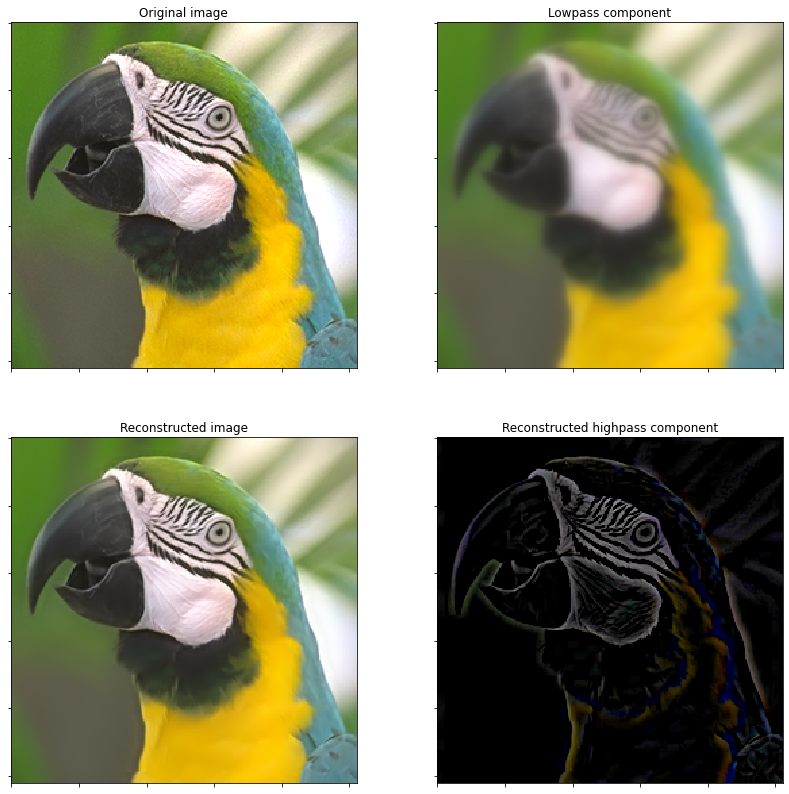

In [9]:
gamma = lambda x, g: np.sign(x) * (np.abs(x)**g)

fig, ax = plot.subplots(nrows=2, ncols=2, figsize=(14, 14))
plot.imview(img, title='Original image', ax=ax[0, 0], fig=fig)
plot.imview(slc, title='Lowpass component', ax=ax[0, 1], fig=fig)
plot.imview(imgr, title='Reconstructed image', ax=ax[1, 0], fig=fig)
plot.imview(gamma(shr, 0.6), title='Reconstructed highpass component',
            ax=ax[1, 1], fig=fig)
fig.show()

Display sparse representation components as sums of absolute values of coefficient maps for $X$, $DX$, and $XB$.

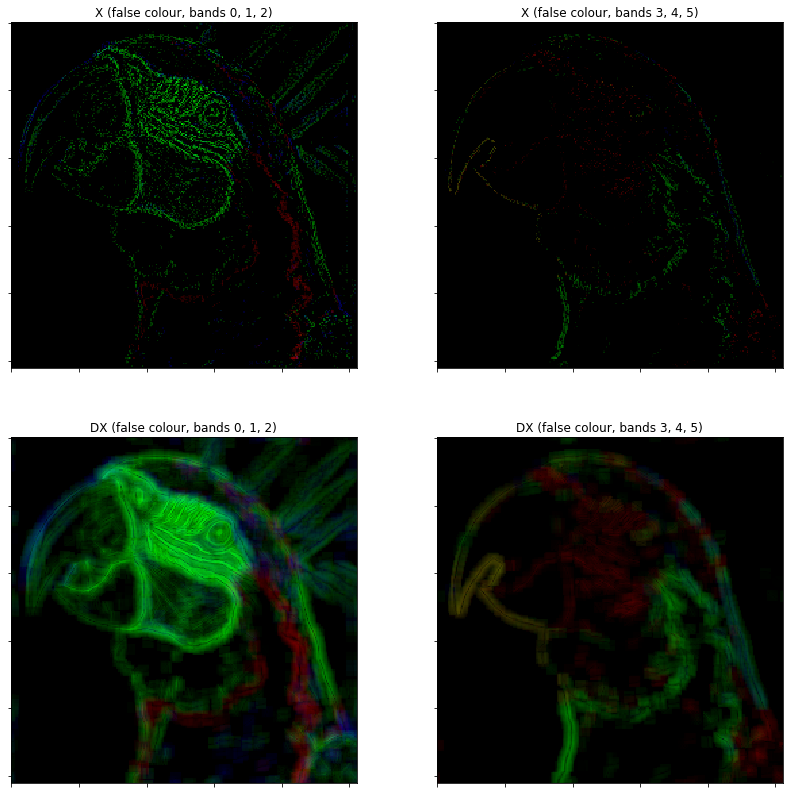

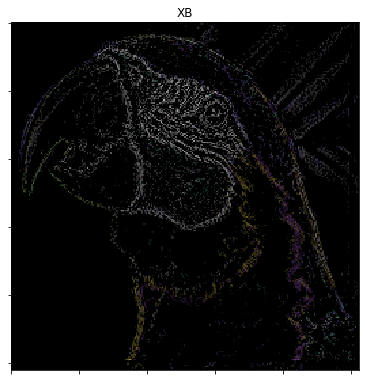

In [10]:
fig, ax = plot.subplots(nrows=2, ncols=2, figsize=(14, 14))
plot.imview(gamma(np.sum(abs(X[..., 0:3, :, :]), axis=b.cri.axisM).squeeze(),
                  0.5), title='X (false colour, bands 0, 1, 2)', ax=ax[0, 0],
            fig=fig)
plot.imview(gamma(np.sum(abs(X[..., 3:6, :, :]), axis=b.cri.axisM).squeeze(),
                  0.5), title='X (false colour, bands 3, 4, 5)', ax=ax[0, 1],
            fig=fig)
plot.imview(gamma(np.sum(abs(DX[..., 0:3, :, :]), axis=b.cri.axisM).squeeze(),
                  0.5), title='DX (false colour, bands 0, 1, 2)', ax=ax[1, 0],
            fig=fig)
plot.imview(gamma(np.sum(abs(DX[..., 3:6, :, :]), axis=b.cri.axisM).squeeze(),
                  0.5), title='DX (false colour, bands 3, 4, 5)', ax=ax[1, 1],
            fig=fig)
fig.show()

plot.imview(gamma(np.sum(abs(XB), axis=b.cri.axisM).squeeze(), 0.5),
            title='XB', fgsz=(6.4, 6.4))

Get iterations statistics from solver object and plot functional value, ADMM primary and dual residuals, and automatically adjusted ADMM penalty parameter against the iteration number.

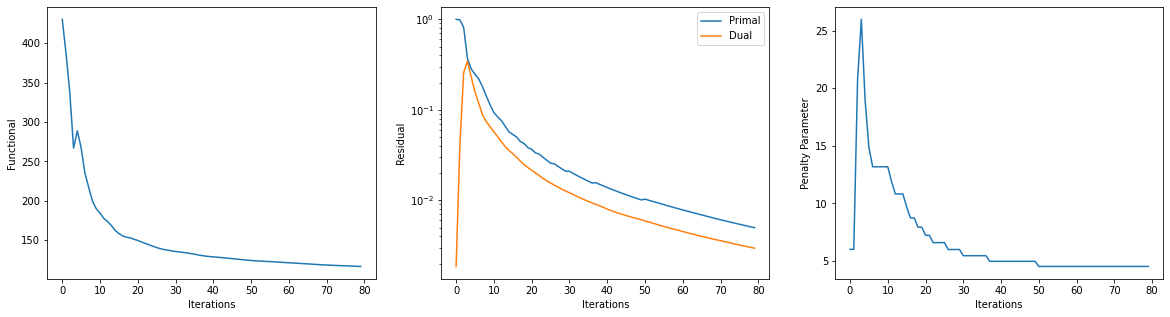

In [11]:
its = b.getitstat()
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(20, 5))
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional', ax=ax[0], fig=fig)
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'], ax=ax[1], fig=fig)
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter', ax=ax[2],
          fig=fig)
fig.show()